In [3]:
import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [4]:
transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset:", len(trainset))
print("testset:", len(testset))


trainset: 60000
testset: 10000


In [5]:
# Shape of an example
print(f"Shape: {len(trainset[0][0][0])}, {len(trainset[0][0][0][0])}")

Shape: 28, 28


In [6]:
# All labels in training set
classes = set([y for _, y in trainset])
classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [7]:
# Function to show images
def show_imgs(imgs):
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(imgs_label)

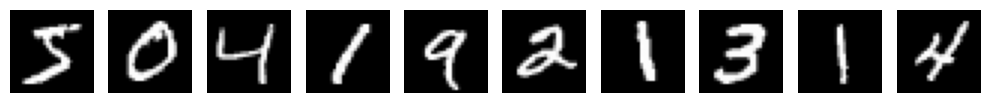

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [8]:
sample_imgs = [trainset[i] for i in range(10)]
show_imgs(sample_imgs)

In [29]:
class MNISTClassifier:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, xavier_init=True, lr=0.0001):
        self.lr = lr

        if xavier_init:
            # uniform Xavier init
            x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
            x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

            self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
            self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        else:
            # random init
            scale = 0.01
            self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim) * scale, requires_grad=True)
            self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim) * scale, requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, y_true):
        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, x):
        self.x = x
        return self.forward()

In [30]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = torch.tensor(np.float64(trainset[0][0].reshape(784)))

In [31]:
# Dummy model (untrained)
dummy = MNISTClassifier()
dummy(x)
dummy_out = dummy.forward() # outputs probabilities for each class
dummy_out_df = pd.DataFrame(dummy_out.detach().numpy(), columns=["Probability"])
dummy_out_df.index.name = "Class"
display(dummy_out_df)
print(f"Actual: {trainset[0][1]}")
print(f"Prediction: {torch.argmax(dummy_out).item()}")

,Probability
Class,
0,0.108389
1,0.105880
2,0.079012
3,0.088877
4,0.089986
5,0.115032
6,0.133373
7,0.085747
8,0.100104


Actual: 5
Prediction: 6


In [32]:
# Define loss functions
def cross_entropy_loss(out, y):
    """
    cross entropy loss: -sum(true_class_distribution * log(predicted_class_distribution))
    """
    # ohe since y is scalar
    # ex. if y is 2 then y_ohe represents class probability distribution of 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    y_ohe = torch.zeros_like(out)
    y_ohe[y] = 1.0

    return np.float64(-torch.sum(y_ohe * torch.log(out +1e-10)))

In [33]:
def criterion(y_pred, y_true, loss_fn):
    return loss_fn(y_pred, y_true)

In [34]:
# Test the loss functions
y_true = 5
y_pred = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.1, 0.1, 0.1, 0.1])

ce = cross_entropy_loss(y_pred, y_true)

print("Cross-entropy loss:", ce)

Cross-entropy loss: 0.6931471824645996


In [36]:
EPOCHS = 10
losses = {
    "base": [],
    "xavier": []
}

In [37]:
base = MNISTClassifier()

# Classic old gradient descent
for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = base(x)

        loss = criterion(output, label, cross_entropy_loss)
        epoch_loss += loss
        
        base.backward(label)
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_loss = epoch_loss / len(trainset)
    losses["base"].append(avg_loss.item())
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Step [0/60000], Loss: 2.2418
Epoch [1/10], Step [1000/60000], Loss: 2.0529
Epoch [1/10], Step [2000/60000], Loss: 2.3079
Epoch [1/10], Step [3000/60000], Loss: 2.2094
Epoch [1/10], Step [4000/60000], Loss: 2.1767
Epoch [1/10], Step [5000/60000], Loss: 2.3466
Epoch [1/10], Step [6000/60000], Loss: 1.9860
Epoch [1/10], Step [7000/60000], Loss: 2.3484
Epoch [1/10], Step [8000/60000], Loss: 1.7190
Epoch [1/10], Step [9000/60000], Loss: 2.2501
Epoch [1/10], Step [10000/60000], Loss: 1.8314
Epoch [1/10], Step [11000/60000], Loss: 1.8721
Epoch [1/10], Step [12000/60000], Loss: 1.9454
Epoch [1/10], Step [13000/60000], Loss: 2.1637
Epoch [1/10], Step [14000/60000], Loss: 1.9101
Epoch [1/10], Step [15000/60000], Loss: 2.2983
Epoch [1/10], Step [16000/60000], Loss: 1.8165
Epoch [1/10], Step [17000/60000], Loss: 1.7553
Epoch [1/10], Step [18000/60000], Loss: 2.0962
Epoch [1/10], Step [19000/60000], Loss: 1.8475
Epoch [1/10], Step [20000/60000], Loss: 2.0113
Epoch [1/10], Step [21000/

In [22]:
xavier = MNISTClassifier(xavier_init=True)

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = xavier(x)

        loss = criterion(output, label, cross_entropy_loss)
        epoch_loss += loss
        
        xavier.backward(label)
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_loss = epoch_loss / len(trainset)
    losses["xavier"].append(avg_loss.item())
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')

Epoch [1/20], Step [0/60000], Loss: 2.1840
Epoch [1/20], Step [1000/60000], Loss: 2.1393
Epoch [1/20], Step [2000/60000], Loss: 2.2880
Epoch [1/20], Step [3000/60000], Loss: 2.3648
Epoch [1/20], Step [4000/60000], Loss: 2.1214
Epoch [1/20], Step [5000/60000], Loss: 2.2377
Epoch [1/20], Step [6000/60000], Loss: 2.0468
Epoch [1/20], Step [7000/60000], Loss: 2.1696
Epoch [1/20], Step [8000/60000], Loss: 1.5042
Epoch [1/20], Step [9000/60000], Loss: 2.3700
Epoch [1/20], Step [10000/60000], Loss: 1.8122
Epoch [1/20], Step [11000/60000], Loss: 1.5634
Epoch [1/20], Step [12000/60000], Loss: 1.8592
Epoch [1/20], Step [13000/60000], Loss: 2.1292
Epoch [1/20], Step [14000/60000], Loss: 1.9908
Epoch [1/20], Step [15000/60000], Loss: 2.4359
Epoch [1/20], Step [16000/60000], Loss: 1.6803
Epoch [1/20], Step [17000/60000], Loss: 1.8520
Epoch [1/20], Step [18000/60000], Loss: 1.7504
Epoch [1/20], Step [19000/60000], Loss: 1.6578
Epoch [1/20], Step [20000/60000], Loss: 2.1603
Epoch [1/20], Step [21000/

In [23]:
# Calculate variance of losses
# var = std^2 = sum((x - mean)^2) / n
for type in losses:
    all_losses = losses[type]
    n = len(all_losses)
    mean = sum(all_losses) / n

    var = sum((x - mean) ** 2 for x in all_losses) / n
    print(f"{type} {mean=:.2f}")
    print(f"{type} {var=:.2f}")

base mean=0.47
base var=0.19
xavier mean=0.37
xavier var=0.07


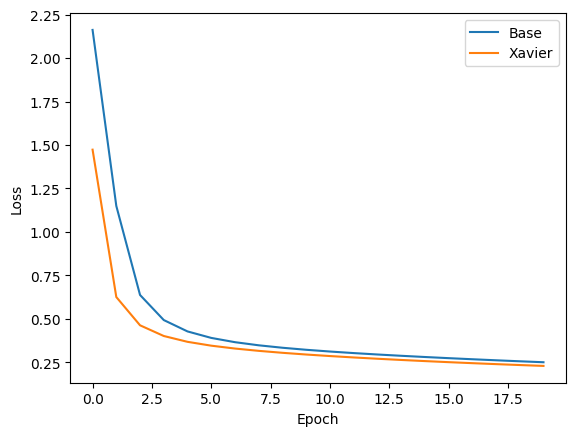

In [24]:
# Plot losses of base and xavier init
plt.plot(losses["base"], label="Base")
plt.plot(losses["xavier"], label="Xavier")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [25]:
results = {
    "base": [],
    "xavier": []
}

In [26]:
# Testing loop
test_loss = 0
correct = 0

for i in range(len(testset)):
   img, label = testset[i]
   x = torch.tensor(np.float64(img.reshape(784)))

   output = base(x)
   loss = criterion(output, label, cross_entropy_loss)
   test_loss += loss
   
   pred = torch.argmax(output)
   correct += (pred == label).item()
   
   if i % 1000 == 0:
       print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
results["base"].append(accuracy)

print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')

Step [0/10000], Loss: 0.0053
Step [1000/10000], Loss: 0.2414
Step [2000/10000], Loss: 0.0263
Step [3000/10000], Loss: 0.0806
Step [4000/10000], Loss: 1.6530
Step [5000/10000], Loss: 0.3162
Step [6000/10000], Loss: 0.2007
Step [7000/10000], Loss: 0.0207
Step [8000/10000], Loss: 0.0002
Step [9000/10000], Loss: 0.0019
avg_test_loss=0.2415, accuracy=93.14%


In [27]:
# Testing loop
test_loss = 0
correct = 0

for i in range(len(testset)):
   img, label = testset[i]
   x = torch.tensor(np.float64(img.reshape(784)))

   output = xavier(x)
   loss = criterion(output, label, cross_entropy_loss)
   test_loss += loss
   
   pred = torch.argmax(output)
   correct += (pred == label).item()
   
   if i % 1000 == 0:
       print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
results["xavier"].append(accuracy)

print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')

Step [0/10000], Loss: 0.0034
Step [1000/10000], Loss: 0.1870
Step [2000/10000], Loss: 0.0375
Step [3000/10000], Loss: 0.0874
Step [4000/10000], Loss: 1.8367
Step [5000/10000], Loss: 0.1977
Step [6000/10000], Loss: 0.2088
Step [7000/10000], Loss: 0.0213
Step [8000/10000], Loss: 0.0001
Step [9000/10000], Loss: 0.0007
avg_test_loss=0.2244, accuracy=93.81%


In [28]:
results_df = pd.DataFrame(results, index=["Accuracy"])
results_df

,base,xavier
Accuracy,93.14,93.81


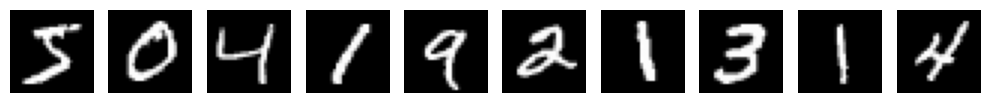

Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


,actual,predicted
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


In [41]:
# Let's use the original sample images
show_imgs(sample_imgs)

pred = { "actual": [y for _, y in sample_imgs], "predicted": [torch.argmax(base.forward(torch.tensor(np.float64(img.reshape(784))))).item() for img, _ in sample_imgs] }
pred_df = pd.DataFrame(pred,)
pred_df

In [ ]:
class MNISTBatchClassifier:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, lr=0.0001):
        self.lr = lr
        # uniform Xavier init
        x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
        x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

        self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
        self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, Y_true):
        batch_size = len(Y_true)

        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, X):
        self.X = X
        return self.forward(X)